Clustering
===
*Bothound project*

# Initialization

In [65]:
# initialization
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.spatial.distance import cdist,pdist
from scipy.signal import argrelextrema
%matplotlib inline
from pylab import *
from numpy import *
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import yaml
from bothound_tools import BothoundTools

stram = open("../conf/bothound.yaml", "r")
conf = yaml.load(stram)
tools = BothoundTools(conf)

color_set = [
    [0, 0, 255],      #Blue
    [255, 0, 0],      #Red
    [0, 255, 0],      #Green
    [255, 255, 0],    #Yellow
    [255, 0, 255],    #Magenta
    [255, 128, 128],  #Pink
    [128, 128, 128],  #Gray
    [128, 0, 0],      #Brown
    [255, 128, 0],    #Orange
]

def get_palette(N=5):
    result = []
    for x in range(N):
        s = color_set[x % len(color_set)]
        result.append([s[0]/255.0,s[1]/255.0,s[2]/255.0,1])
    return result
palette = get_palette(30)

def plot_costs(costs, num_clusters, title):
    KK = range(1,len(costs)+1)

    # elbow curve
    kIdx = num_clusters      
    clr = cm.spectral( np.linspace(0,1,10) ).tolist()
    mrk = 'os^p<dvh8>+x.'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(KK, costs, 'b*-')
    ax.plot(num_clusters, costs[num_clusters-1], marker='o', markersize=14, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    #ax.set_ylim((0,100))
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within sum of squeres')
    plt.title(title)
    
def get_best_clustering_model(X, max_number_of_clusters, title):
    cost = []
    KK = range(1,max_number_of_clusters+1)
    kms = []
    # calculate all the clustering and cost
    for no_of_clusters in KK:
        km = KMeans(n_clusters=no_of_clusters, precompute_distances = True, max_iter = 500, n_init = 30)
        km.fit(X)
        kms.append(km)

        sizes = [0]*no_of_clusters
        for i in km.predict(X): 
            sizes[i] = sizes[i]+1
        print sizes

        #centroids = km.cluster_centers_ 
        #distances = cdist(X, centroids, 'euclidean')
        #cIdx = np.argmin(distances,axis=1) 
        #dist = np.min(distances,axis=1) 
        #tot_withinss = sum(dist**2)  # Total within-cluster sum of squares

        #cost.append(tot_withinss / X.shape[0]) 
        cost.append(km.inertia_)

    # calculate first derivative
    derivative1 = [cost[i+1]-cost[i] for i in range(len(cost)-1)]
    #print derivative1

    # calculate second derivative
    derivative2 = [derivative1[i+1]-derivative1[i] for i in range(len(derivative1)-1)]
    #print derivative2

    max2 = argrelextrema(np.argsort(derivative2), np.less) 
    num_clusters = 4 
    if(len(max2[0]) > 0):
        num_clusters = max2[0][0] + 3
    else:
        # calculate third derivative
        derivative3 = [derivative2[i+1]-derivative2[i] for i in range(len(derivative2)-1)]
        #print derivative3

        max3 = argrelextrema(np.argsort(derivative3), np.greater) 
        if(len(max3[0]) > 0):
            num_clusters = max3[0][0] + 4 

    model = kms[num_clusters-1]
    sizes = [0]*model.n_clusters
    clusters = model.predict(X)
    for i in clusters: 
        sizes[i] = sizes[i]+1
    print sizes

    left = [] 
    for i in range(len(sizes)):
        left.append(i)

    fig = plt.figure()
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.bar(left,sizes, color = palette)            
    return clusters, model.n_clusters, cost

def plot3(feature_indexes, X, clusters, selected_cluster):
    if(selected_cluster >= 0):
        X_plot = X[clusters == selected_cluster,: ]
        labels_plot = labels[clusters == selected_cluster]
    else:
        X_plot = X[clusters >= 0,: ]
        labels_plot = labels[clusters >= 0]
    
    colors = []
    for i in labels_plot:
        colors.append(palette[i])

    fig = figure(figsize=(24,24))
    ax = fig.gca(projection='3d')
    #fig = plt.figure(figsize=(14,14))
    #ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel(features[feature_indexes[0]])
    ax.set_ylabel(features[feature_indexes[1]])
    ax.set_zlabel(features[feature_indexes[2]])
    azim = 125
    elev = 15
    #ax.set_autoscale_on(False)
    ax.view_init(elev, azim) 

    # plot points in 3D
    class1 = 0.6 * random.standard_normal((200,3))
    x = X_plot[:,feature_indexes[0]]
    y = X_plot[:,feature_indexes[1]]
    z = X_plot[:,feature_indexes[2]]
    
    ax.scatter(x,y,z, s=5, edgecolors='none', c = colors, marker='o')

    #ax.set_xlim([-1,5])
    #ax.set_ylim([-1,5])
    #ax.set_zlim([-1,5])



# Configuration

In [66]:
#Report Configuration
id_incident = 19

features = [
    "request_interval", #1
    #"ua_change_rate",#2
    "html2image_ratio",#3
    "variance_request_interval",#4
    #"payload_average",#5
    #"error_rate",#6
    #"request_depth",#7
    #"request_depth_std",#8
    "session_length",#9
    #"percentage_cons_requests",#10
]

max_number_of_clusters = 8


# Read & Preprocess

In [67]:
# Reading from Database
tools.connect_to_db()
incident = tools.get_incident(id_incident)
sessions = tools.get_sessions(id_incident)
tools.disconnect_from_db()

print "Incident {} loaded:".format(id_incident)
print "Start: {}".format(incident[0]["start"])
print "Srop : {}".format(incident[0]["stop"])
print "Comment : {}".format(incident[0]["comment"])
values = []
for s in sessions:
    row = []
    for f in features:
        row.append(s[f])
    values.append(row)
X = np.array(values)

print X.shape

# normalization 
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)


Incident 19 loaded:
Start: 2015-12-19 00:00:00
Srop : 2015-12-19 00:04:00
Comment : Test incident 2
(21664, 4)


# PCA Clustering

[21664]
[8786, 12878]
[12080, 8802, 782]
[10919, 8774, 1197, 774]
[8773, 10887, 788, 1196, 20]
[10564, 787, 8771, 1350, 172, 20]
[8768, 10394, 303, 172, 1347, 678, 2]
[8763, 9376, 303, 160, 2, 981, 674, 1405]
[10564, 787, 8771, 1350, 172, 20]
Num clusters(PCA): 6


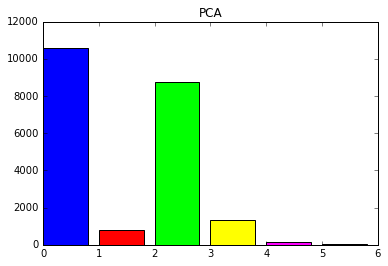

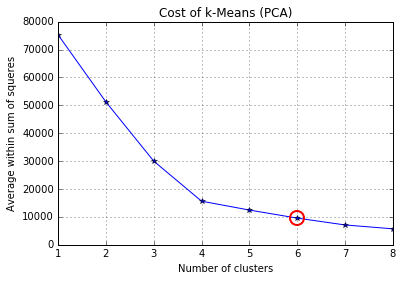

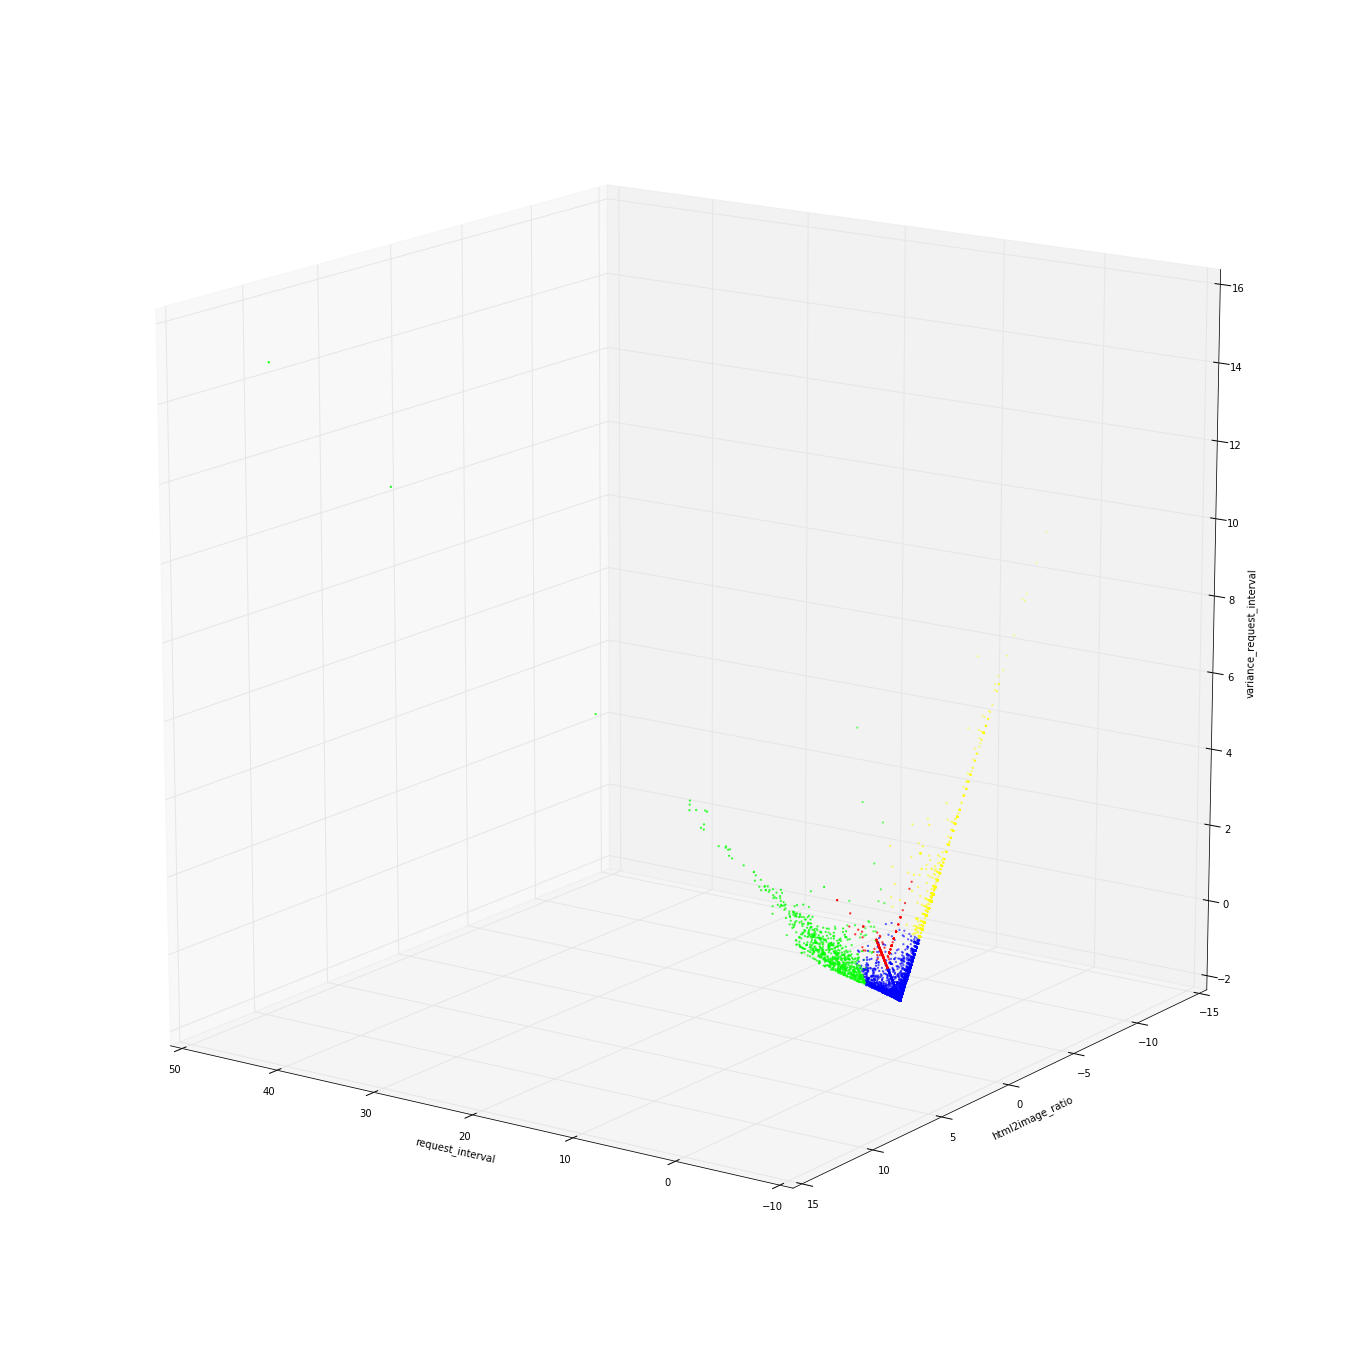

In [68]:
# perform PCA dimensionality reduction

#PCA to 3 dimensions for visualisation
pca = sklearn.decomposition.RandomizedPCA(n_components=3).fit(X)
X_pca = pca.transform(X)

# elbow methos fpr PCA
clusters_pca, num_clusters_pca, costs_pca = get_best_clustering_model(X_pca, max_number_of_clusters, "PCA")
print "Num clusters(PCA):", num_clusters_pca
plot_costs(costs_pca, num_clusters_pca, "Cost of k-Means (PCA)")
plot3([0,1,2], X_pca, clusters_pca, -1)

# Clustering 

[21664]
[8783, 12881]
[8794, 12051, 819]
[10895, 8766, 1196, 807]
[10883, 817, 8766, 2, 1196]
[762, 10830, 110, 1196, 8764, 2]
[10506, 8762, 110, 1351, 2, 761, 172]
[8757, 10246, 1342, 436, 2, 618, 91, 172]
[10895, 8766, 1196, 807]
Num clusters: 4


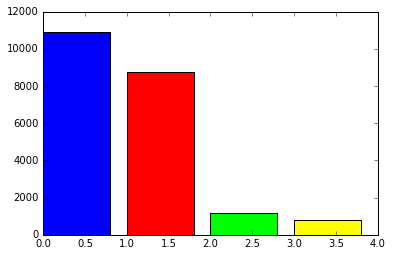

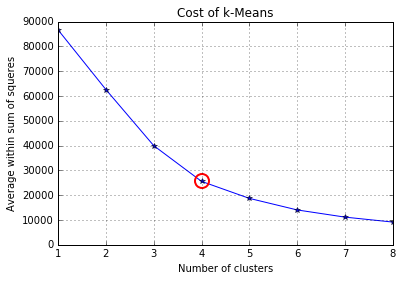

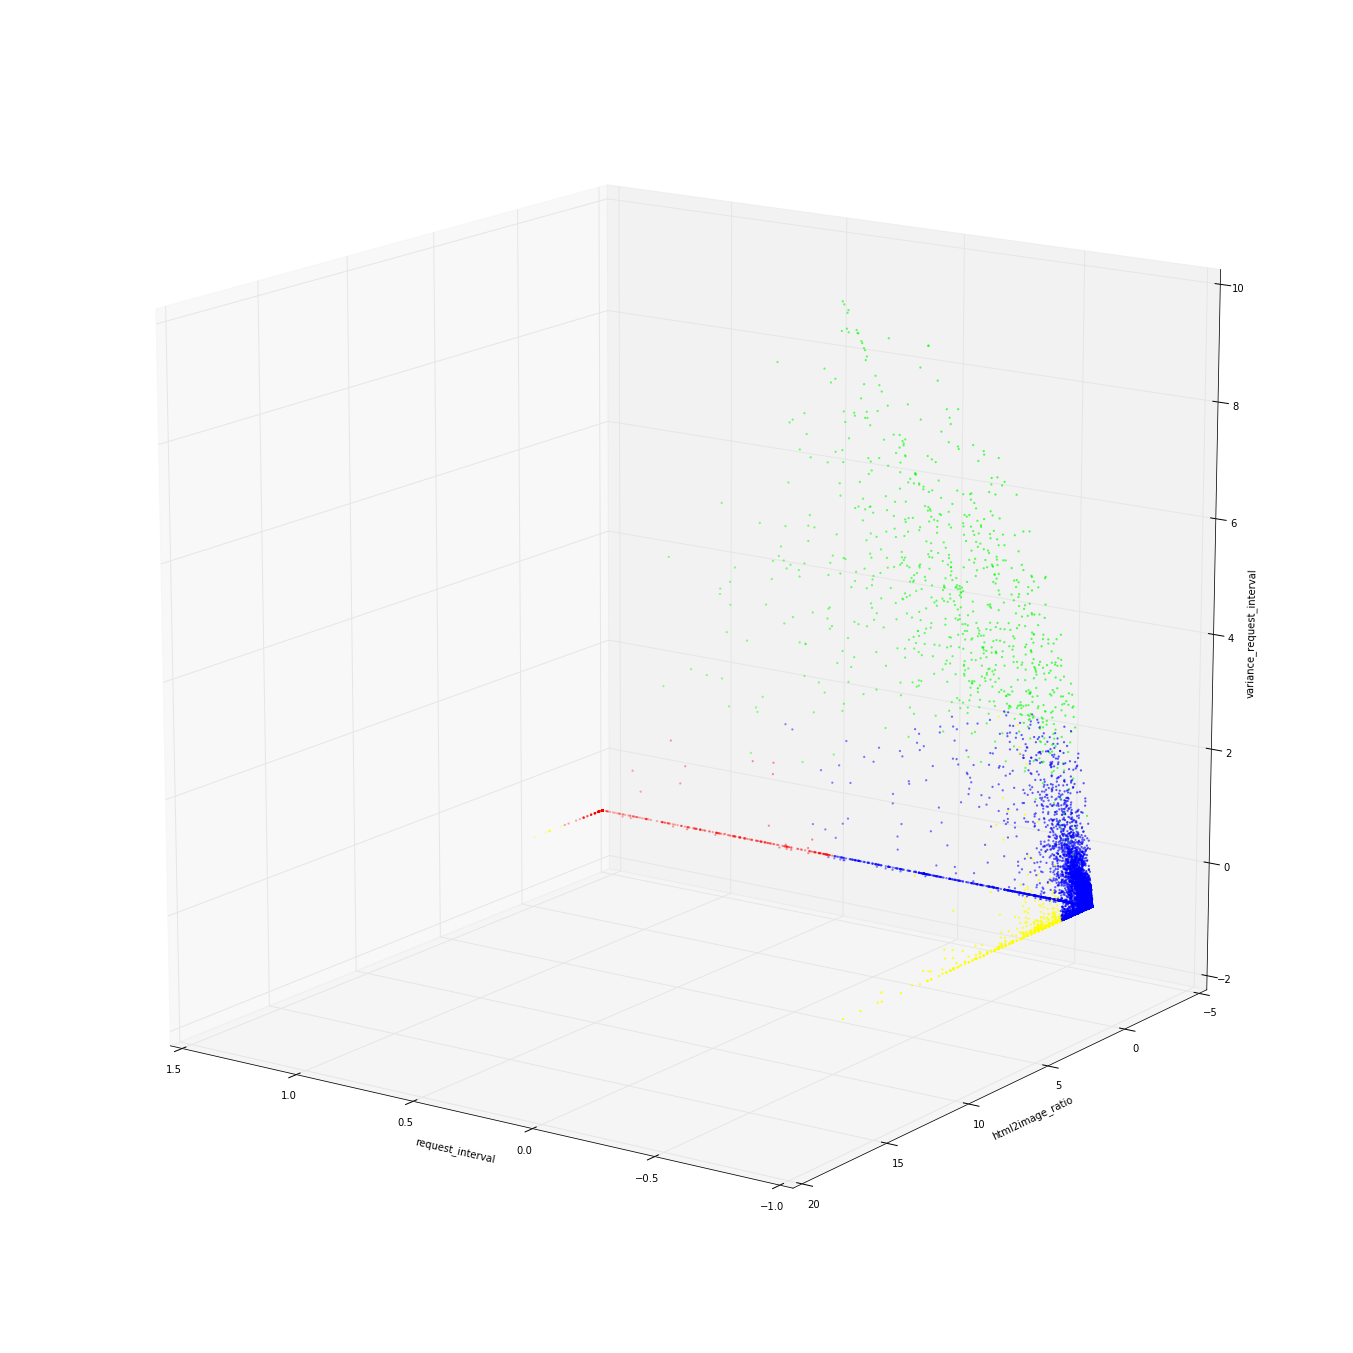

In [69]:
# K-Means
clusters, num_clusters, costs = get_best_clustering_model(X, max_number_of_clusters, "")
print "Num clusters:", num_clusters
plot_costs(costs, num_clusters, "Cost of k-Means")
plot3([0,1,2], X, clusters, -1)


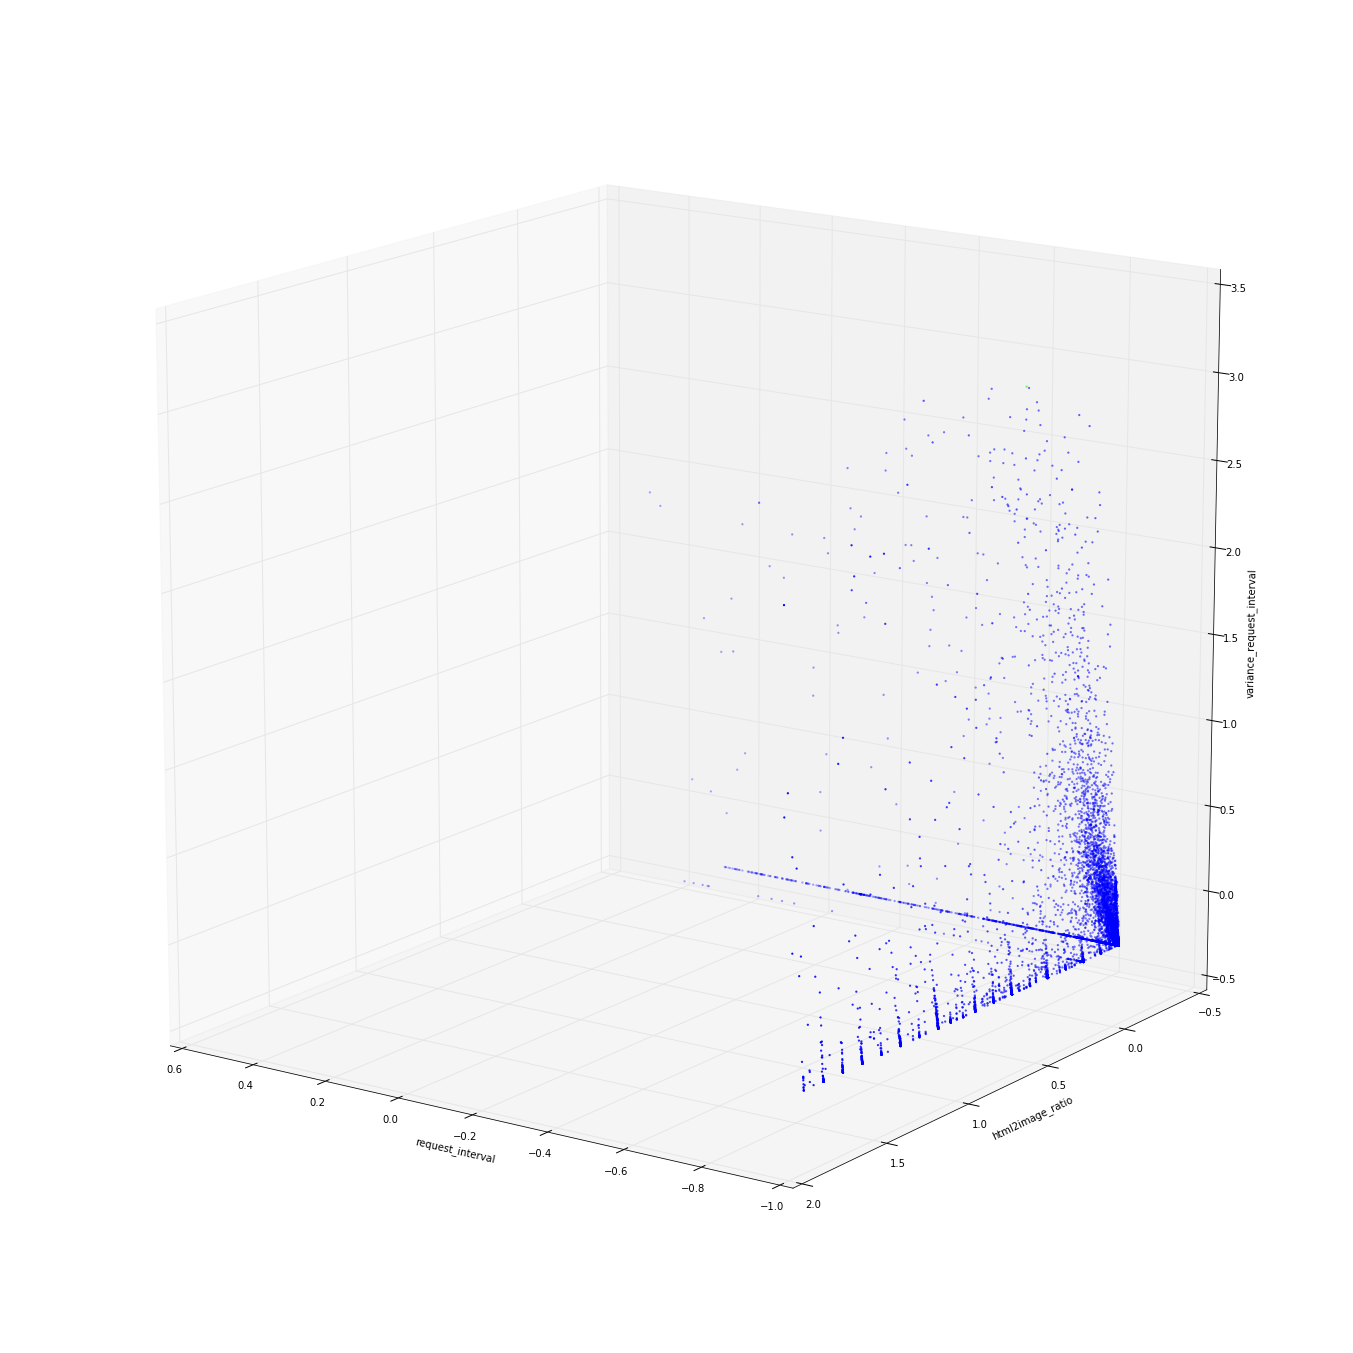

In [70]:
plot3([0,1,2], X, clusters, 0)